# Part 3: Multiple Linear Model

## Problem Statement:

**According to the Ames, Iowa housing data, which regression model can most accurately predict a house's price? As a result, why should millenials choose to live in Ames based on the most important housing features determined by the optimal regression model?** 

[The Ames Iowa Housing Data](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) contains 81 variables that were used in computing assessed values for individual residential properties sold from 2006 to 2010. I will be using various regression models, such as Linear Regression, LassoCV, and RidgeCV, to determine which model most accurately fits the data by comparing RMSE and $R^2$ scores.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
from scipy import stats
import statsmodels.api as sm
import string
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import VarianceThreshold
from statistics import mode
import pickle

np.random.seed(3_0_0)

DO = '#7D1B7E'
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
train_df = pd.read_csv('../datasets/train_clean_EDA.csv', keep_default_na=False)

In [3]:
train_df.isnull().sum().sum()

0

Now that the dataset is clean, I will start modeling.

Since the objective of the project is to simultaneously minimize a model's RMSE score and maximize the R2 score, I need to set a baseline model because it will return the highest RMSE and lowest R2 score. I will then know whether any future models are improving by comparing future RMSE and R2 scores to the baseline model's.

Features of the Naive Baseline Model:

- True Y plotted against the predicted Y which is the mean of true Y in this case
- No scaling necessary, because none of the predictor variables are used for modeling

In [4]:
train_df['Mean_y_hat'] = train_df['SalePrice'].mean()

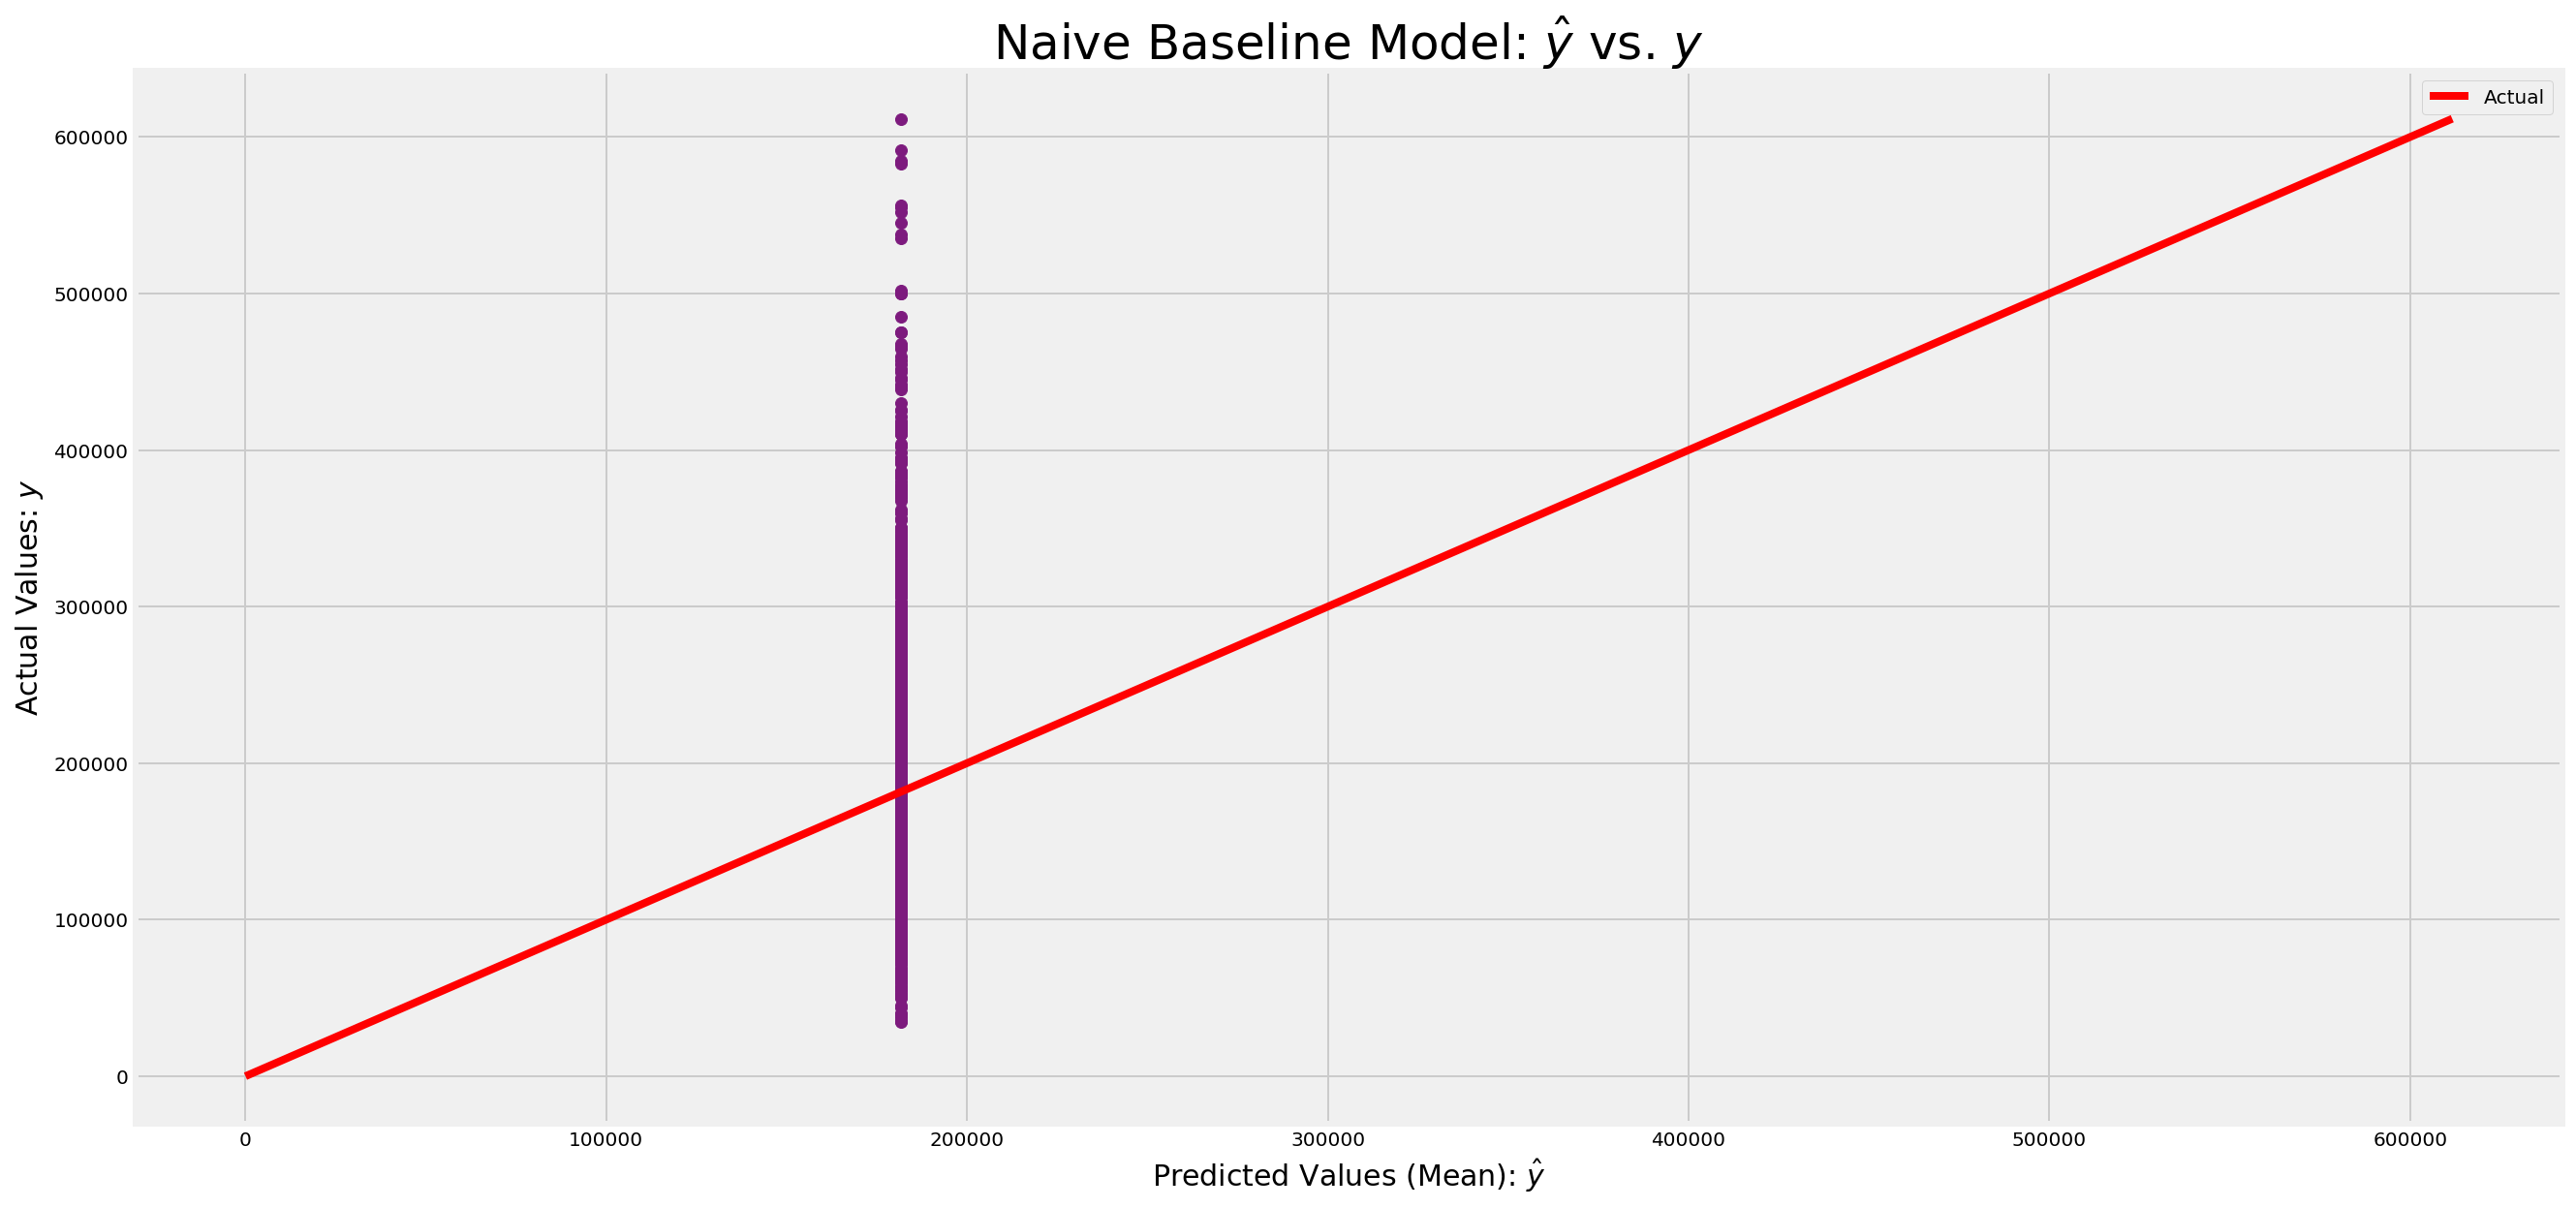

In [5]:
y_hat_nb = train_df['Mean_y_hat']
y_true_nb = train_df['SalePrice']
plt.figure(figsize = (20,10))
plt.scatter(y_hat_nb , y_true_nb, c = DO);
plt.plot((0,np.max(y_true_nb)),(0,np.max(y_true_nb)), c = 'red');
plt.xlabel("Predicted Values (Mean): $\hat{y}$", fontsize = 15);
plt.ylabel("Actual Values: $y$", fontsize = 15);
plt.title("Naive Baseline Model: $\hat{y}$ vs. $y$", fontsize = 25);
plt.legend(['Actual']);

In [6]:
def model_score(y_true,y_hat):
    
    RMSE = mean_squared_error(y_true , y_hat)**0.5
    R2 = r2_score(y_true,y_hat)
    MAE = mean_absolute_error(y_true,y_hat)
    MedAE = median_absolute_error(y_true,y_hat)
    
    print(f'Mean Absolute Error: {MAE}\nMedian Absolute Error: {MedAE}\nRoot Mean Squared Error: {RMSE}\nR2: {R2}')


In [7]:
model_score(y_true_nb, y_hat_nb)

Mean Absolute Error: 58289.67340994822
Median Absolute Error: 46634.19668130795
Root Mean Squared Error: 79102.79570906215
R2: 0.0


All models will be scored according to the 4 metrics above.
Though all 4 of the metrics indicate whether a model is 'good' or not by examining the magnitiude of the model's residual errors, it is important to have a variety of metrics to compare to in order to examine which predictor variables most contribute to the sale price.

**Mean Absolute Error** - The MAE is 58358, which appears to be quite high. The MAE is useful because the score is less sensitive to the errors because it is not squared. 

**Median Absolute Error** - The MedAE is 46469, which appreas to be quite high as well. The MedAE is less sensitive to outliers than the both the RMSE and MAE.

**Root Mean Squared Error** - The RMSE is 79239, which is quite large. As the metric represents the average distance from the predicted sales price value, we have to minimize the score in order to have an accurate model. Predictions are plus or minus $79239 which is a huge range and largely inaccurate.

**R2 score** - Not surprisingly, the baseline model does not explain any of the target data's variability around its mean. The predictions are imprecise. The goal is to increase the R2 score as close to 100% as possible so that the variability in the data can be explained by the model. 

With these baseline scores, I will look to minimize the Mean Absolute Error, Median Absolute Error, and Root Mean Squared Error as close to 0 as possible. I will also create a model that has a higher R2 model. 

In [8]:
train_df.drop('Mean_y_hat',1,inplace=True)

## Multiple Linear Regression (All Variables)

I will now implement a multiple linear regression and see whether the  metric scores improve.

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_{1i} + \hat{\beta}_2 X_{2i} + \cdots + \hat{\beta}_p X_{pi}$$

In a MLR, the model will attempt to calculate the predicted Sale Price based on the predictor variables, which are the various house features.

Features of the MLR:
- X values - All predictor variables will be included in this model
- Scaler - All predictor variables will be feature scaled by using standard scaler because the difference in magnitudes are too large among numerical predictor variable variances due to their respective units. 
- All object predictor variables will be cast as dummy variables
- A train test split will be utilized to train the model and see how the model performs with 'unseen' (test) inputs.
- The magnitude of the beta coefficients will indicate which features influence the sale price the most. 

In [9]:
train_dummies = pd.get_dummies(train_df)

The 43 object variables turned into dummy variables, so now there are 317 predictor variables as opposed to 77 predictor variables.

In [10]:
train_df.dtypes.value_counts()

object     43
int64      24
float64    10
dtype: int64

In [11]:
train_dummies.dtypes.value_counts()

uint8      283
int64       24
float64     10
dtype: int64

In [12]:
def model_creator(dataframe, y_col, model_type = LinearRegression(), trainsize = 0.7):

    X = dataframe.drop(columns = y_col, axis = 1)
    y = dataframe[y_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= 42, train_size = trainsize);
    
    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    
    model = model_type
    model.fit(X_train_sc,y_train)
    
    R2_train = model.score(X_train_sc, y_train)
    R2_test = model.score(X_test_sc, y_test)
    
    y_hat = model.predict(X_test_sc)
    
    
    plt.figure(figsize = (20,10))
    plt.scatter(y_hat,y_test, c = DO);
    plt.plot((0,np.max(y_test)),(0,np.max(y_test)), c = 'red');
    plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20);
    plt.ylabel("Actual Values: $y$", fontsize = 20);
    plt.title("$\hat{y}$ vs. $y$", fontsize = 30);
    plt.legend(['Actual']);
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    
    print(f'Train Size: {trainsize*100}%')
    print(f'Train R2 Score: {R2_train}')
    print(f'Test R2 Score: {R2_test}')
    
    return y_test, y_hat

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train Size: 70.0%
Train R2 Score: 0.9440678101050313
Test R2 Score: -3.790317689035291e+20


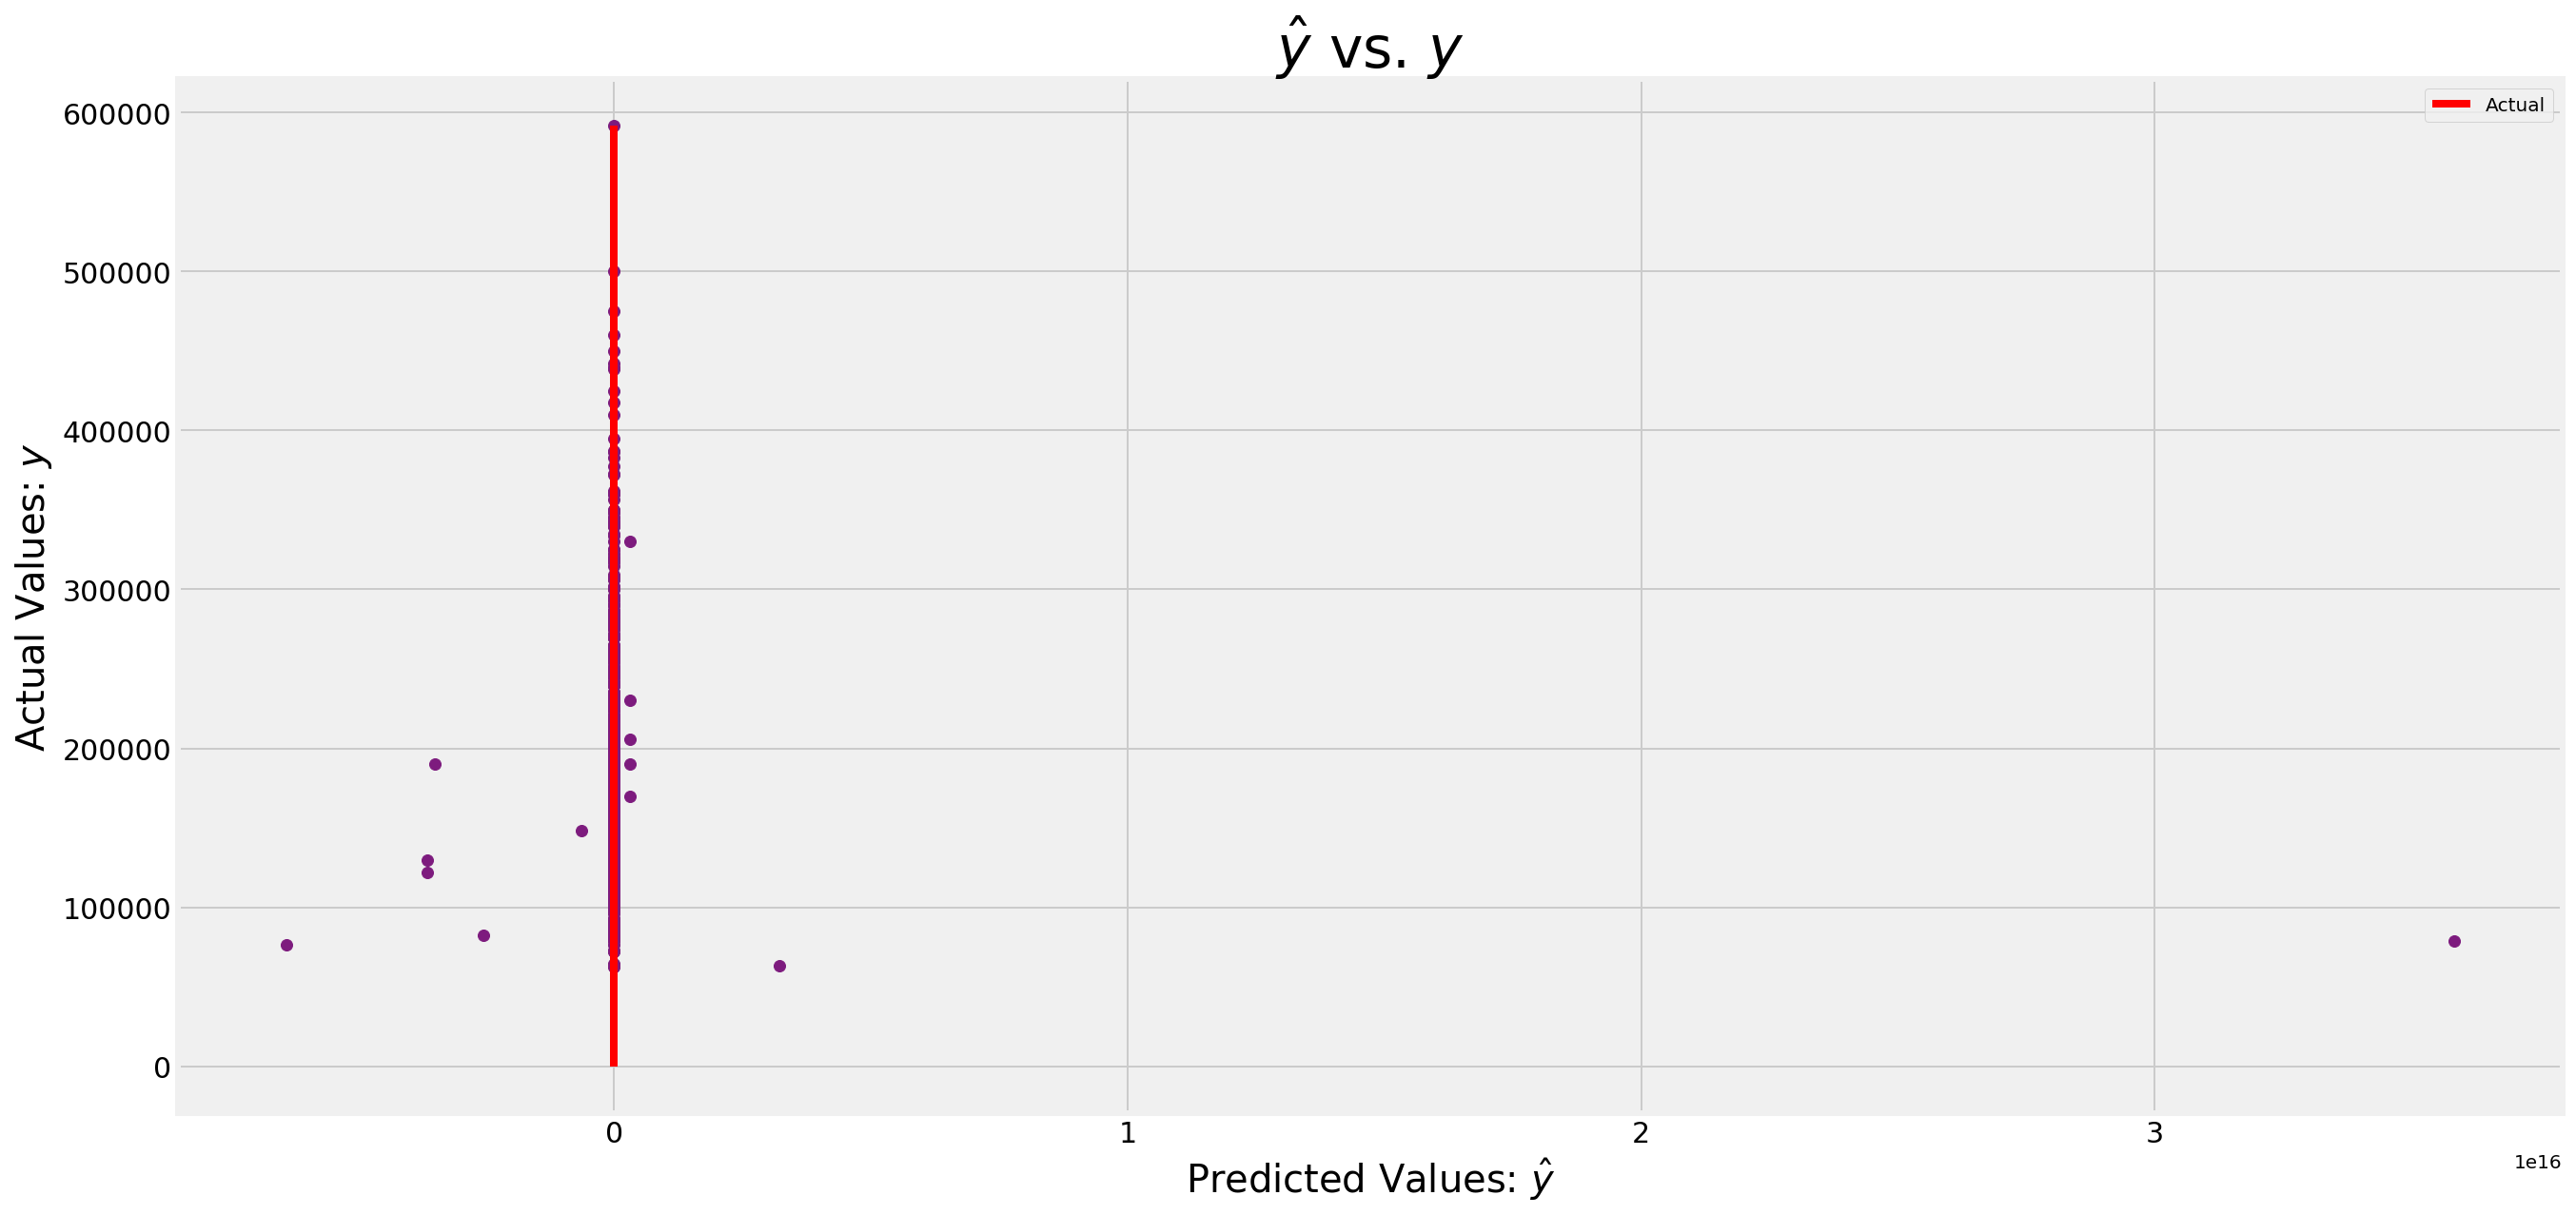

In [13]:
y_test_mlr, y_hat_mlr = model_creator(train_dummies, 'SalePrice', trainsize = 0.7)

In [14]:
model_score(y_test_mlr, y_hat_mlr)

Mean Absolute Error: 99075398900331.88
Median Absolute Error: 11282.74168488264
Root Mean Squared Error: 1498368672986160.0
R2: -3.790317689035291e+20


Clearly, this model is trash. Besides the median absolute error being lower than our naive baseline model's, every other metric is worse.

Based on the predicted values vs. actual values scatterplot and the scores, it appears that there are too many variables that are skewing the data points. In order to remedy this, we will apply a variance threshold, which removes predictors with variation below a certain cutoff. 

Usually when a predictor does not have a large spread of variance, it has little predictive power.

## Multiple Linear Regression (w/ Variance Threshold)

The higher the variance threshold, the fewer predictor variables the model will have.

Based on the formula:

</p> <div class="math">\[\mathrm{Var}[X] = p(1 - p)\]</div>


I will choose p = 0.05 which returns roughly:

</p> <div class="math">\[\mathrm{Var}[X] = 0.05\]</div>

In [15]:
X = train_dummies.drop(columns = 'SalePrice', axis = 1)
y = train_dummies['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= 42, train_size = 0.7);

In [16]:
threshold = VarianceThreshold(.05)

In [17]:
X_train_thresh = threshold.fit_transform(X_train)
X_test_thresh = threshold.transform(X_test)
predictor_variables = X.columns[threshold.get_support()]

Train R2 Score: 0.8830182947368892
Test R2 Score: 0.8873112438385947


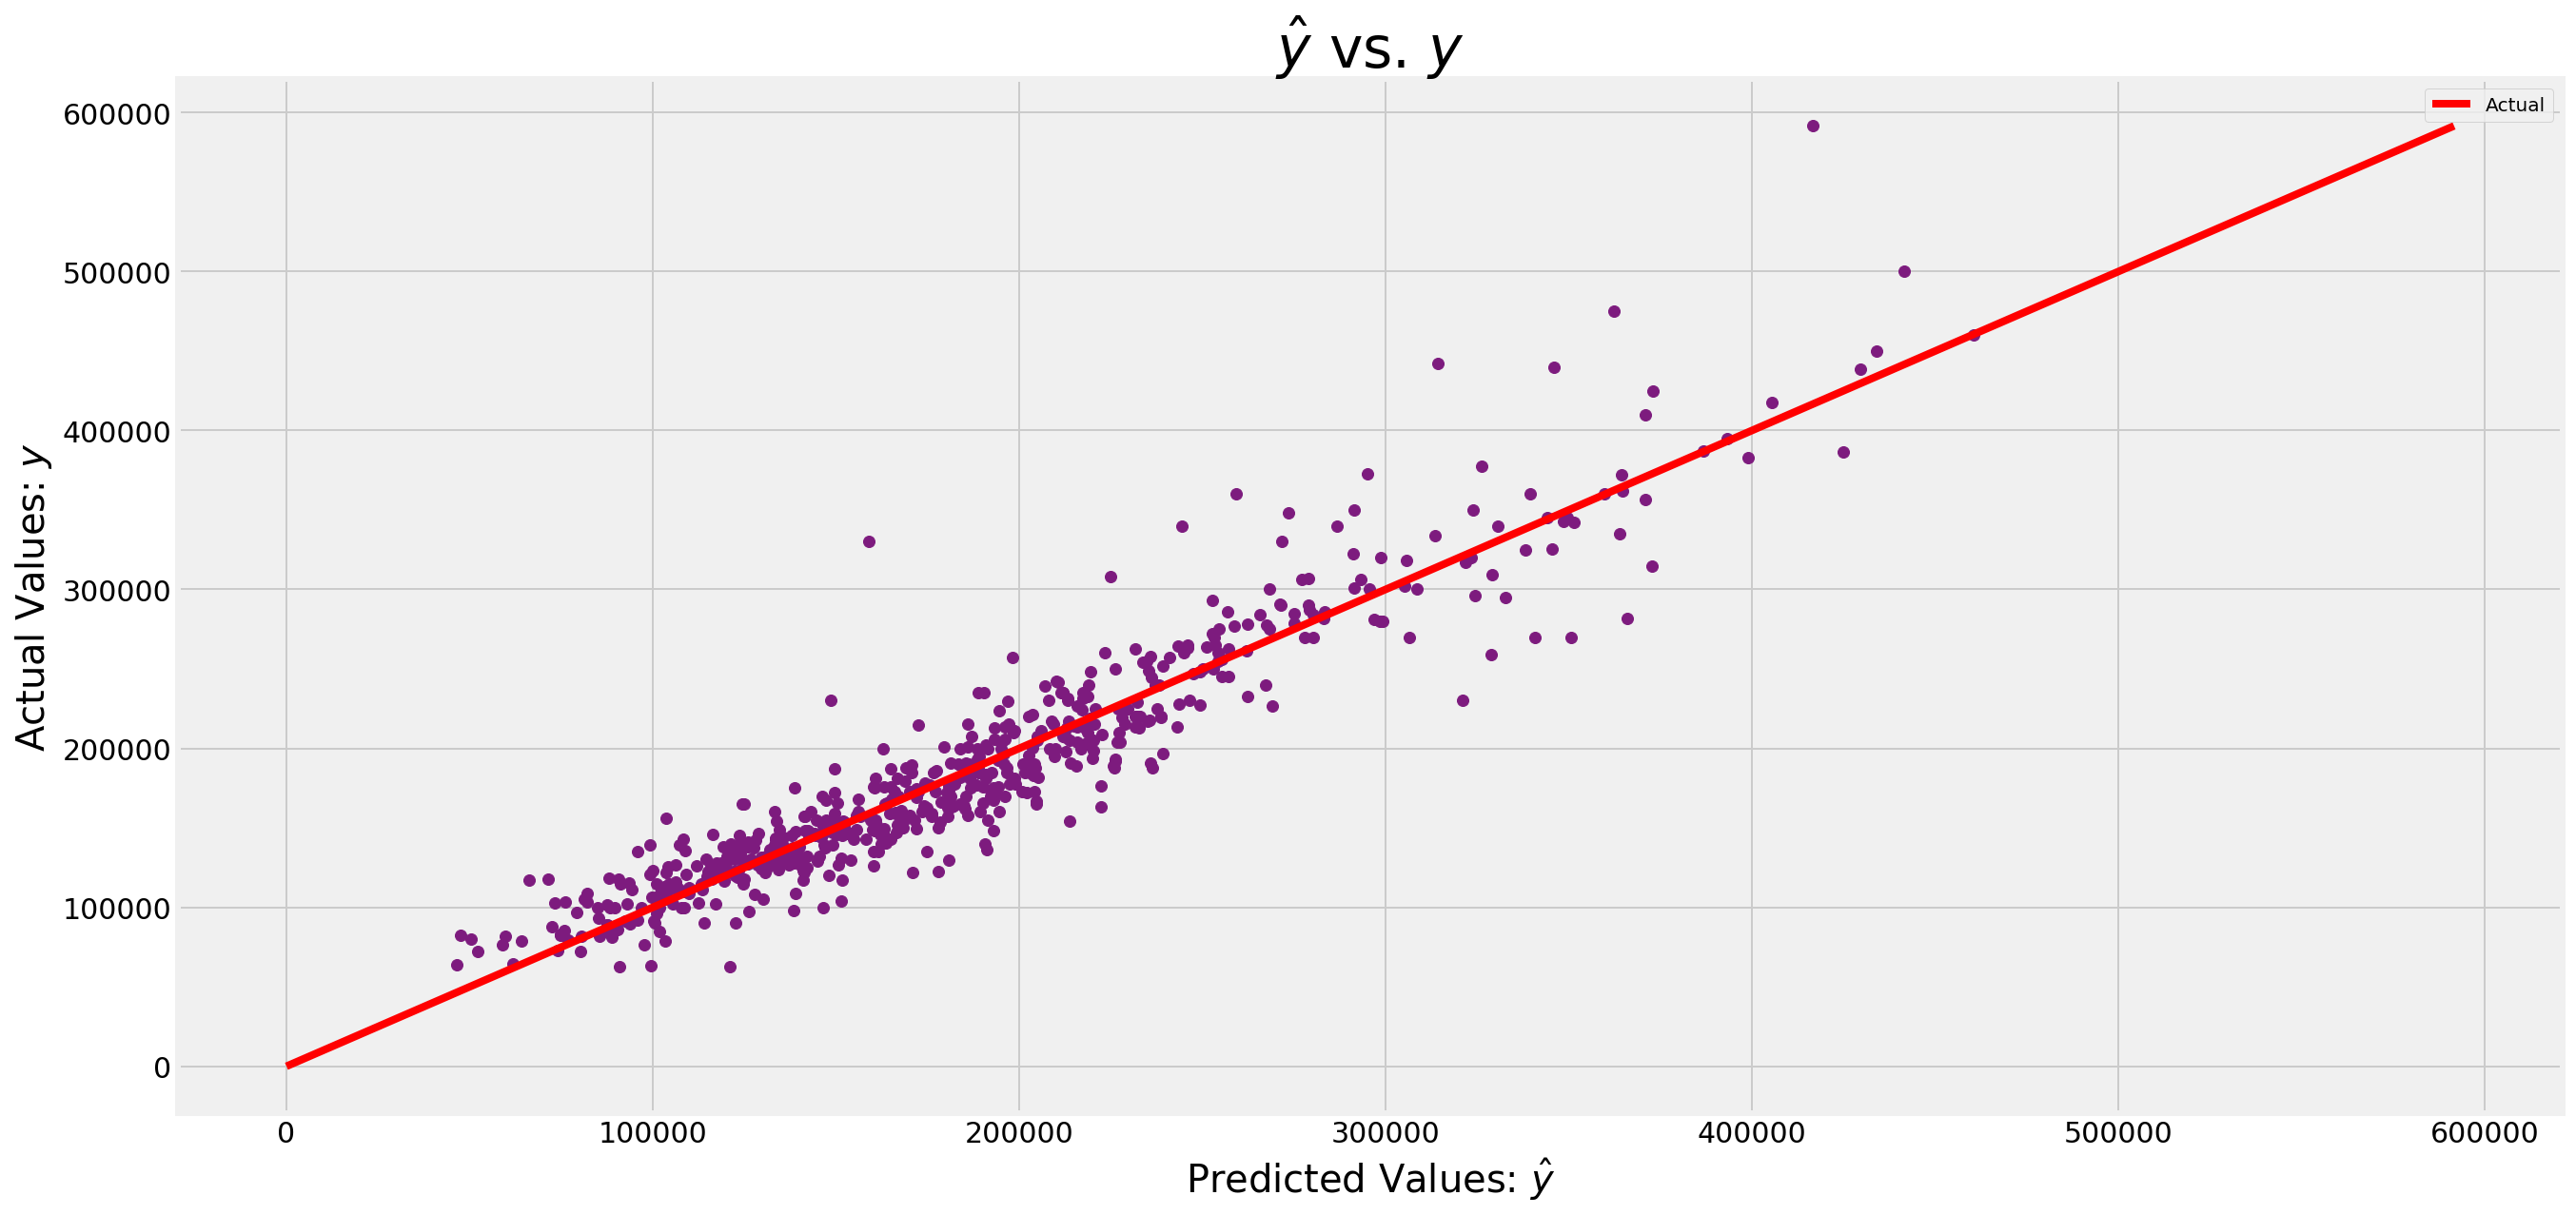

In [18]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train_thresh)
X_test_sc = ss.transform(X_test_thresh)

model = LinearRegression()
model.fit(X_train_sc,y_train)
   
R2_train = model.score(X_train_sc, y_train)
R2_test = model.score(X_test_sc, y_test)
   
y_hat = model.predict(X_test_sc)
   
plt.figure(figsize = (20,10))
plt.scatter(y_hat,y_test, c = DO);
plt.plot((0,np.max(y_test)),(0,np.max(y_test)), c = 'red');
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20);
plt.ylabel("Actual Values: $y$", fontsize = 20);
plt.title("$\hat{y}$ vs. $y$", fontsize = 30);
plt.legend(['Actual']);
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

print(f'Train R2 Score: {R2_train}')
print(f'Test R2 Score: {R2_test}')

In [19]:
model_score(y_test, y_hat)

Mean Absolute Error: 17436.279547094193
Median Absolute Error: 12688.67865297338
Root Mean Squared Error: 25835.755802053227
R2: 0.8873112438385946


In [20]:
print(f'With the variance threshold, there are {len(predictor_variables)} predictor variables in the above multiple linear regression model')

With the variance threshold, there are 128 predictor variables in the above multiple linear regression model


In this model, around 88% of the Sale Price variability can be explained by the predictor variables. Furthermore, all four metrics have performed better than both our naive baseline model and the multiple linear regression with all variables. 

The high and similar R2 scores for both the train and test cases may indicate that the model has high variance and may be overfit. Furthermore, due to the high number of predictor variables in the model, there might be an inflation in the R2 score.

The RMSE indicates that the model's predicted sale price is around $25000 off target.

The number of predictor variables have decreased from 320 to 128. 

I will now iterate through a range of variance thresholds (0.01,0.02,...,0.99, 1) to see which variance threshold will return the best metric scores.

In [21]:
variance_threshold_values = list(np.linspace(.01,1,100))

In [22]:
RMSE_list = []
R2_list = []
MAE_list = []
MedAE_list = []
num_predictor_variables = []

for threshold in variance_threshold_values:
    
    X = train_dummies.drop(columns = 'SalePrice', axis = 1)
    y = train_dummies['SalePrice']
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= 42, train_size = 0.7);
    
    threshold = VarianceThreshold(threshold)
    X_train_thresh = threshold.fit_transform(X_train)
    X_test_thresh = threshold.transform(X_test)
    pred_variables = X.columns[threshold.get_support()]
    
    
    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train_thresh)
    X_test_sc = ss.transform(X_test_thresh)
    
    lr = LinearRegression()
    lr.fit(X_train_sc,y_train)
       
    y_hat = lr.predict(X_test_sc)
    
    
    RMSE = mean_squared_error(y_test , y_hat)**0.5
    R2 = r2_score(y_test,y_hat)
    MAE = mean_absolute_error(y_test,y_hat)
    MedAE = median_absolute_error(y_test,y_hat)
    
    RMSE_list.append(RMSE)
    R2_list.append(R2)
    MAE_list.append(MAE)
    MedAE_list.append(MedAE)
    
    num_predictor_variables.append(pred_variables)

min_RMSE_index = RMSE_list.index(min(RMSE_list))
max_RMSE_index = R2_list.index(max(R2_list))
min_MAE_index = MAE_list.index(min(MAE_list))
min_MedAE_index = MedAE_list.index(min(MedAE_list))

best_model = mode([min_RMSE_index,max_RMSE_index, min_MAE_index, min_MedAE_index])

print(f'Variance Threshold: {variance_threshold_values[best_model]}')
print(f'MAE: {MAE_list[best_model]}')
print(f'MedAE: {MedAE_list[best_model]}')
print(f'RMSE: {RMSE_list[best_model]}')
print(f'R2: {R2_list[best_model]}')

print(f'Number of Predictor Variables: {len(num_predictor_variables[best_model])}')

Variance Threshold: 0.01
MAE: 17525.52992641742
MedAE: 12403.097236145579
RMSE: 25249.000901585507
R2: 0.8923716607461223
Number of Predictor Variables: 216


A variance threshold of 0.01 returns the lowest MAE, MedAE, and RMSE scores and the highest R2 score. 

However, with a decrease of variance threshold from 0.05 to 0.01, the number of predictor variables increase from 128 to 216. Furthermore, the difference between the 0.05 variance threshold's metric scores and 0.01 variance threshold's is negligible:


| Metric | VT (0.01) | VT (0.05) | Abs. Diff. |
|---|---|---|---| 
| Mean Absolute Error | 17525 | 17436 | 89 |
| Median Absolute Error | 12403 | 12688 | 285 |
| Root Mean Squared Error | 25249 | 25835 | 586 |
| R2 | 0.892 | 0.887 | 0.005 |
| # of  Predictor Variables | 216 | 128 | 88 |

I will stick with the Variance Threshold of 0.05 because there are fewer predictor variables and the model does not improve much. 

I will now examine which predictor variables have a most contribute to a house's sale price by examining their beta coefficients.

In [23]:
beta_df = pd.DataFrame({'Predictor Variables' : predictor_variables, 'Beta':model.coef_})
beta_df = beta_df.set_index('Predictor Variables')
beta_df['Absolute_Beta'] = abs(beta_df['Beta'])
beta_df = beta_df.sort_values('Absolute_Beta', ascending = False)

beta_df.head()

,Beta,Absolute_Beta
Predictor Variables,,
BsmtFin_SF_1,4.994835e+15,4.994835e+15
Total_Bsmt_SF,-4.791475e+15,4.791475e+15
Bsmt_Unf_SF,4.658179e+15,4.658179e+15
Garage_Qual_NA,4.008499e+15,4.008499e+15
Gr_Liv_Area,-3.678448e+15,3.678448e+15


The y intercept, $\beta_0$, which can be interpreted as the house's base price without any features is roughly $180,140 :

In [24]:
beta_0 = model.intercept_
beta_0

180140.9199980649

In [25]:
weights = beta_df['Beta'].head(10)
labels = list(beta_df.index)[:10]

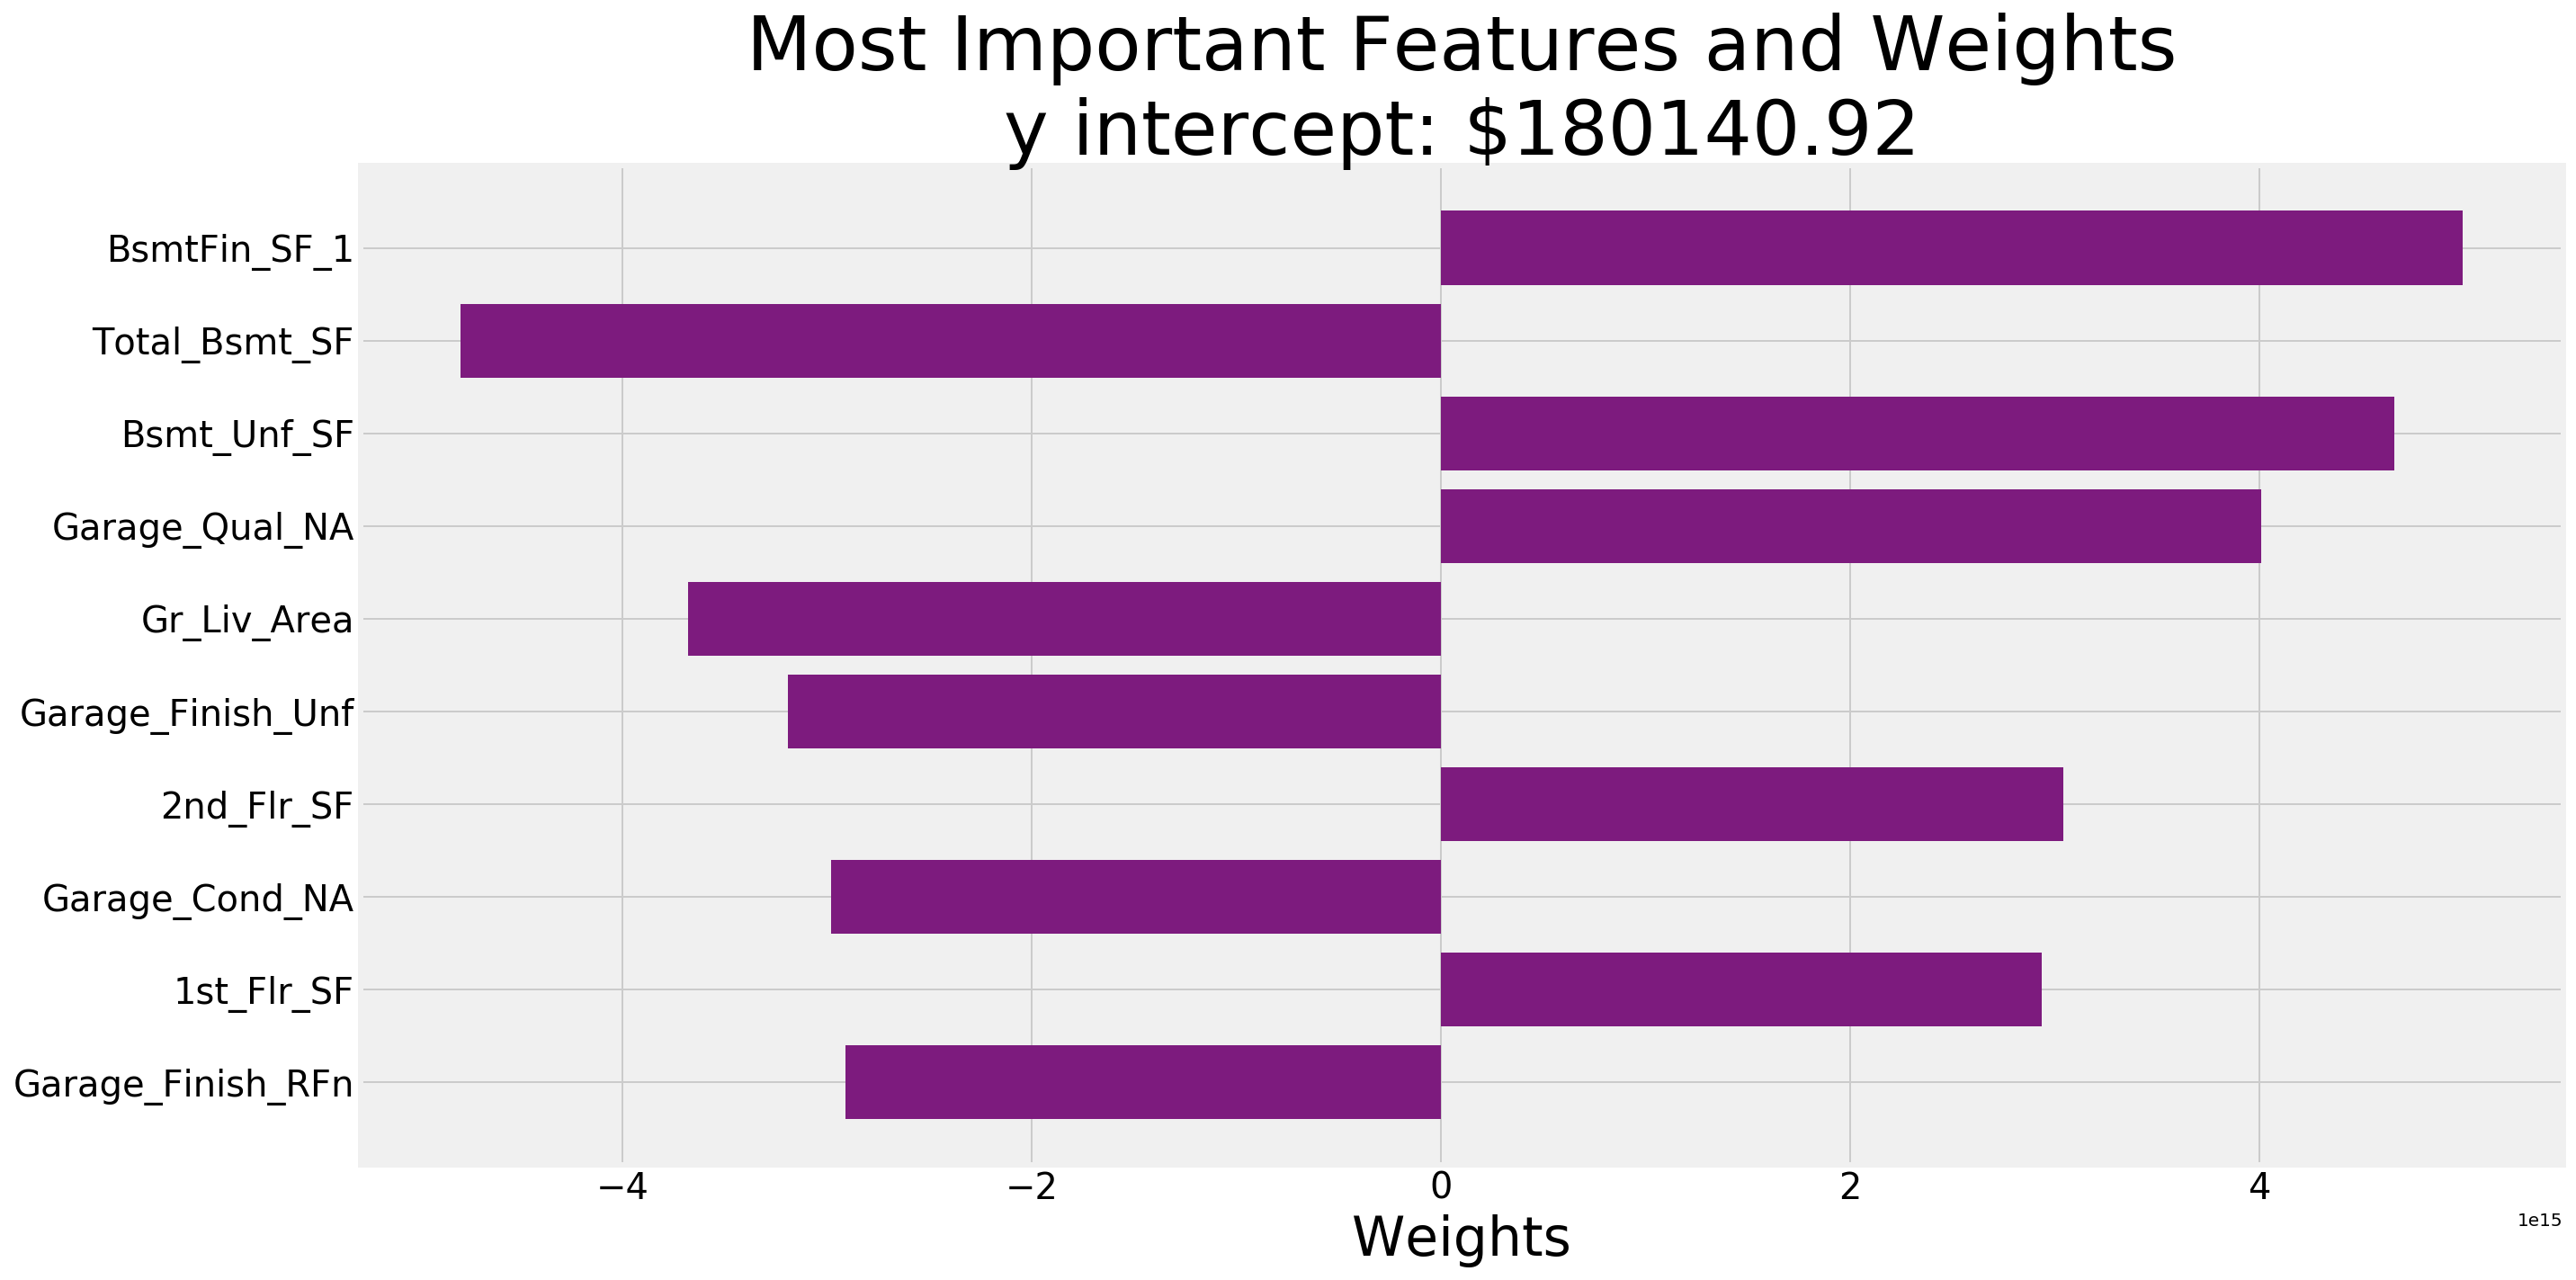

In [26]:
plt.figure(figsize=(20,10))
plt.barh(labels[::-1], weights[::-1], color = DO)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${beta_0:0.02f}', fontsize=42)
plt.tight_layout()

The top 10 predictor variables indicate how an increase in one standard deviation in one predictor variable while holding all else constant will affect the target prediction, Sale Price. 

For example, a 1 unit standard deviation increase in the total basement square footage will decrease the sale price by -4.791 * $10^{15}$ deviations. 

According to the linear regression model, the basement Type 1 finished square feet, the total basement in square feet, and the unfinished basement in square feet all impact the sale price the most.

Unfortunately, there might be an issue of collinearity between the predictor variables. For example, the total basement square feet (`Total_Bsmt_SF`) most likely includes the Type 2 finished square feet (`BsmtFin_SF_2`), Unfinished square feet of basement area (`Bsmt_Unf_SF`), and Type 1 finished square feet (`BsmtFin_SF_1`).

Overall, the model does not quite make sense. One would imagine an increase in the basement square footage and ground living area to increase the house's price, but instead the increase in square footage lowers the price. In addition, houses with no garages will also increase a house's price, which does not align with my assumptions. 

Moving forward:
- The high R2 score from both the train and test split is an indication of high variance because of the 128 predictor variables. The next step is to use regularization in order to discourage a model from being overfit by either minimizing or removing the beta coefficients to reduce variance.

In [27]:
train_dummies.to_csv('../datasets/train_dummies.csv', index = False)

# Please go to Part 4: Ridge & Lasso Model